In [1]:
import tensorflow as tf
import numpy as np
import os,pathlib

In [2]:
#方法定义

def preprocess_data(dataset):
    all_images = []
    all_labels = []
    for image,label in dataset:
        preprocessed_image = tf.keras.applications.resnet50.preprocess_input(image)
        all_images.append(preprocessed_image)
        all_labels.append(label)
    return np.concatenate(all_images),np.concatenate(all_labels)

def get_r_list():
    index_out_list = []
    name_out_list = []
    for i,layer in enumerate(base_model.layers):
        if layer.name[-3:] == 'out':
            index_out_list.append(i)
            name_out_list.append(layer.name)
    index_r_list = []
    name_r_list = []
    for j in range(len(name_out_list)-1):
        if name_out_list[j][0:5] != name_out_list[j+1][0:5]:
            index_r_list.append(index_out_list[j])
            name_r_list.append(name_out_list[j])
    r_list = [0]
    for i in index_r_list:
        r = i/len(base_model.layers)
        r_list.append(r)
    return r_list

def build_model():
    x = conv_base.output
    predictions = classifier(x)
    model = tf.keras.Model(inputs=conv_base.input,outputs=predictions)
    return model

def r_compiled_model():
    model = build_model()
    for layer in model.layers[:int(r*len(conv_base.layers))+1]:
        layer.trainable = False
    for layer in model.layers[int(r*len(conv_base.layers))+1:]:
        layer.trainable = True
        if isinstance(layer,tf.keras.layers.BatchNormalization):
            layer.trainable = False
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001,momentum=0.9),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [3]:
#加载数据、预处理数据

base_dir = pathlib.Path('chest_xray2/label')
train_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'train',
                                                            image_size=(224,224),
                                                            batch_size=32)
validation_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'val',
                                                                 image_size=(224,224),
                                                                 batch_size=32)
train_images,train_labels = preprocess_data(train_dataset)
val_images,val_labels = preprocess_data(validation_dataset)

Found 100 files belonging to 2 classes.
Found 160 files belonging to 2 classes.


In [4]:
#分类器初训练

base_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False)

inputs = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
x = tf.keras.layers.Dense(units=256,activation='relu')(x)
outputs = tf.keras.layers.Dense(units=1,activation='sigmoid')(x)
classifier_model = tf.keras.Model(inputs=inputs,outputs=outputs)

x = base_model.output
predictions = classifier_model(x)
model = tf.keras.Model(inputs=base_model.input,outputs=predictions)

for layer in model.layers[:len(base_model.layers)]:
    layer.trainable = False
    
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
callback_list = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
                 tf.keras.callbacks.ModelCheckpoint(filepath='resnet50_r_1.00.keras',
                                                    monitor='val_accuracy',
                                                    save_best_only=True)]
history = model.fit(train_images,train_labels,
                    epochs=15,
                    validation_data=(val_images,val_labels),
                    callbacks=callback_list)
r_1_acc = max(history.history['val_accuracy'])
print(r_1_acc)

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - ETA: 0s - loss: 6.7149 - accuracy: 0.4800WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002119B848E18> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

In [5]:
#搜索最佳迁移率R(验证理论)

classifier_p = model.get_layer(model.layers[-1].name)
r_list = get_r_list()
best_acc = r_1_acc
r_acc = []

for i in range(len(r_list)):
    r = r_list[i]
    conv_base = tf.keras.applications.resnet50.ResNet50(weights='imagenet',include_top=False)
    classifier = classifier_p
    model = r_compiled_model()
    filepath = 'resnet50_r_{:.2f}.keras'.format(r)
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=2),
                 tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                                    monitor='val_accuracy',
                                                    save_best_only=True)]
    history = model.fit(train_images,train_labels,
                        epochs=15,
                        validation_data=(val_images,val_labels),
                        callbacks=callbacks)
    r_acc.append(max(history.history['val_accuracy']))
    
    if i == 0 and r_acc[0] < r_1_acc:
        r_list = r_list[:1]+r_list[:0:-1]
        continue
    if r_acc[i] > best_acc:
        best_acc = r_acc[i]

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - ETA: 0s - loss: 0.1496 - accuracy: 0.9600WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002119D4CA620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) an

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
4/4 [==============================] - 24s 6s/step - loss: 0.1466 - accuracy: 0.9600 - val_loss: 0.1427 - val_accuracy: 0.9500
Epoch 2/15
4/4 [==============================] - 19s 5s/step - loss: 0.1419 - accuracy: 0.9600 - val_loss: 0.1450 - val_accuracy: 0.9500
Epoch 3/15
4/4 [==============================] - 20s 5s/step - loss: 0.1347 - accuracy: 0.9600 - val_loss: 0.1573 - val_accuracy: 0.9500


In [6]:
#观察结果

print(r_list)
print(r_acc)

[0, 0.21714285714285714, 0.45714285714285713, 0.8114285714285714]
[0.949999988079071, 0.949999988079071, 0.949999988079071, 0.949999988079071]


In [7]:
##整理结果

#r_list.pop(0)
#r_0_acc = r_acc.pop(0)

#r_list.append(0)
#r_acc.append(r_0_acc)

#r_list.insert(0,1)
#r_acc.insert(0,r_1_acc)

r_list.append(1)
r_acc.append(r_1_acc)
print(r_list)
print(r_acc)

[0, 0.21714285714285714, 0.45714285714285713, 0.8114285714285714, 1]
[0.949999988079071, 0.949999988079071, 0.949999988079071, 0.949999988079071, 0.949999988079071]


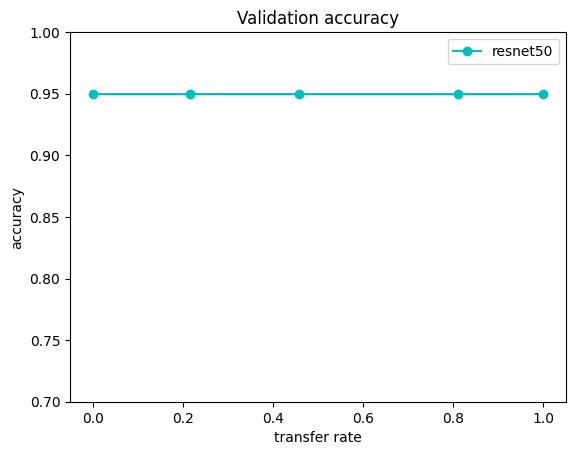

In [8]:
#展示结果

import matplotlib.pyplot as plt
plt.figure()
plt.plot(r_list,r_acc,linestyle='-',marker='o',color='c',label='resnet50')
plt.xlabel('transfer rate')
plt.ylabel('accuracy')
plt.ylim((0.7,1))

plt.title('Validation accuracy')
plt.legend()
plt.show()


In [ ]:
#将BN层冻结的作用对resnet50来说不大，下面就不再弄了

In [10]:
#在unlabel(test)数据集上测试

base_dir = pathlib.Path('chest_xray2')
test_dataset = tf.keras.utils.image_dataset_from_directory(base_dir/'unlabel',
                                                            image_size=(224,224),
                                                            batch_size=32)
test_images,test_labels = preprocess_data(test_dataset)

Found 1000 files belonging to 2 classes.


In [11]:
model_0 = tf.keras.models.load_model('resnet50_r_0.00.keras')
model_1 = tf.keras.models.load_model('resnet50_r_0.22.keras')
model_2 = tf.keras.models.load_model('resnet50_r_0.46.keras')
model_3 = tf.keras.models.load_model('resnet50_r_0.81.keras')
model_4 = tf.keras.models.load_model('resnet50_r_1.00.keras')

In [12]:
r_acc_t = []
test_loss,test_acc = model_0.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 59s 2s/step - loss: 0.2428 - accuracy: 0.9030
0.902999997138977


In [13]:
test_loss,test_acc = model_1.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 54s 2s/step - loss: 0.2426 - accuracy: 0.8990
0.8989999890327454


In [14]:
test_loss,test_acc = model_2.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 55s 2s/step - loss: 0.2377 - accuracy: 0.9020
0.9020000100135803


In [15]:
test_loss,test_acc = model_3.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 56s 2s/step - loss: 0.2346 - accuracy: 0.9000
0.8999999761581421


In [16]:
test_loss,test_acc = model_4.evaluate(test_images,test_labels)
print(test_acc)
r_acc_t.append(test_acc)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
32/32 [==============================] - 56s 2s/step - loss: 0.2706 - accuracy: 0.8980
0.8980000019073486


In [18]:
print(r_acc_t)

[0.902999997138977, 0.8989999890327454, 0.9020000100135803, 0.8999999761581421, 0.8980000019073486]


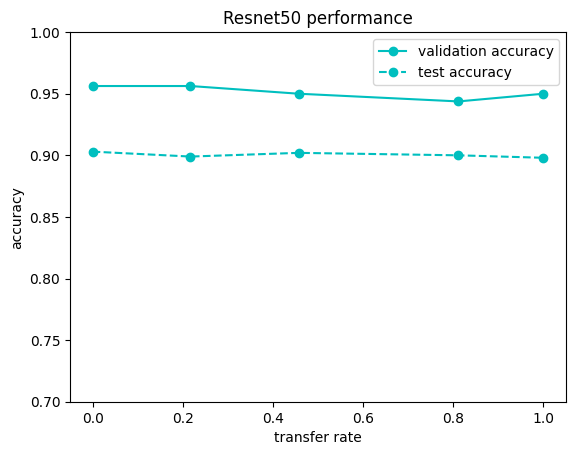

In [21]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(r_list,r_acc,linestyle='-',marker='o',color='c',label='validation accuracy')
plt.plot(r_list,r_acc_t,linestyle='--',marker='o',color='c',label='test accuracy')
plt.xlabel('transfer rate')
plt.ylabel('accuracy')
plt.ylim((0.7,1))

plt.title('Resnet50 performance')
plt.legend()
plt.show()

In [22]:
#在unlabel(test)数据集上测试聚类
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

In [23]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_0.get_layer('conv5_block3_out').output)
encoder_0 = tf.keras.Model(inputs=model_0.input,outputs=feature)
X = encoder_0.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [27]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.123


In [28]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_1.get_layer('conv5_block3_out').output)
encoder_1 = tf.keras.Model(inputs=model_1.input,outputs=feature)
X = encoder_1.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [29]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.871


In [30]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_2.get_layer('conv5_block3_out').output)
encoder_2 = tf.keras.Model(inputs=model_2.input,outputs=feature)
X = encoder_2.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [31]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.865


In [32]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_3.get_layer('conv5_block3_out').output)
encoder_3 = tf.keras.Model(inputs=model_3.input,outputs=feature)
X = encoder_3.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [34]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.124


In [35]:
feature = tf.keras.layers.GlobalAveragePooling2D()(model_4.get_layer('conv5_block3_out').output)
encoder_4 = tf.keras.Model(inputs=model_4.input,outputs=feature)
X = encoder_4.predict(test_images)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [37]:
kmeans = KMeans(n_clusters=2, n_init=20)
y_pred = kmeans.fit_predict(X)
acc = accuracy_score(test_labels,y_pred)
print(acc)

0.127


In [38]:
r_acc_k = [1-0.123,0.871,0.865,1-0.124,1-0.127]
print(r_acc_k)

[0.877, 0.871, 0.865, 0.876, 0.873]


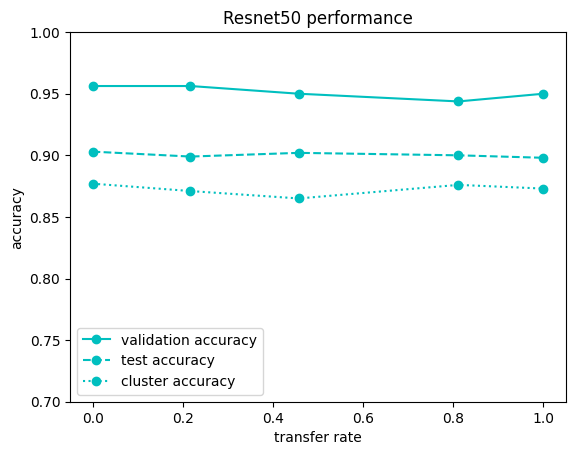

In [39]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(r_list,r_acc,linestyle='-',marker='o',color='c',label='validation accuracy')
plt.plot(r_list,r_acc_t,linestyle='--',marker='o',color='c',label='test accuracy')
plt.plot(r_list,r_acc_k,linestyle=':',marker='o',color='c',label='cluster accuracy')
plt.xlabel('transfer rate')
plt.ylabel('accuracy')
plt.ylim((0.7,1))

plt.title('Resnet50 performance')
plt.legend()
plt.show()